<a href="https://colab.research.google.com/github/Bharathi-Krishna/LSTM/blob/main/gan_faces_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os, random, itertools, math
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob

torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# !ls /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real
# !ls /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2

ls: cannot access '/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2': No such file or directory


In [3]:
import kagglehub

kagglehub.dataset_download(
  "xhlulu/140k-real-and-fake-faces",
)

Using Colab cache for faster access to the '140k-real-and-fake-faces' dataset.


'/kaggle/input/140k-real-and-fake-faces'

In [64]:
IMG_SIZE = 256        # Face image size
IMG_CHANNELS = 3      # RGB

## parameters
Z_DIM = 200           # 2x latent dimension for diversity
G_HIDDEN = 64 # G
D_HIDDEN = 64 # D
BATCH_SIZE = 256
G_LR = 3e-4       # Higher generator learning rate
D_LR = 1e-4       # Lower discriminator learning rate
BETAS = (0.5, 0.999) #common
EPOCHS = 20 # common


OUT_DIR = "CONFIG_4_AGGRESSIVE_G'"
os.makedirs(OUT_DIR, exist_ok=True)

In [65]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Get all image files
        print(f"Searching for images in: {root_dir}") # Added print statement
        self.image_files = glob.glob(os.path.join(root_dir, "*.jpg")) + \
                          glob.glob(os.path.join(root_dir, "*.jpeg")) + \
                          glob.glob(os.path.join(root_dir, "*.png"))
        print(f"Found {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, 0  # dummy label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a random image instead
            return self.__getitem__((idx + 1) % len(self.image_files))

In [66]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # [-1, 1] for RGB
])

In [67]:
data_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real"

 # <-- Update this path

train_ds = FaceDataset(data_path, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print(f"Dataset size: {len(train_ds)}, Batches: {len(train_loader)}")

Searching for images in: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real
Found 50000 images
Dataset size: 50000, Batches: 196


In [68]:
import os


print(f"Contents of {data_path}:")
try:
    for item in os.listdir(data_path):
        print(item)
except FileNotFoundError:
    print(f"Directory not found: {data_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Streaming output truncated to the last 5000 lines.
19524.jpg
47374.jpg
42311.jpg
25584.jpg
46815.jpg
68125.jpg
51544.jpg
24950.jpg
28535.jpg
37904.jpg
69385.jpg
13618.jpg
41363.jpg
52031.jpg
39816.jpg
33600.jpg
39177.jpg
59701.jpg
47787.jpg
48359.jpg
35370.jpg
05937.jpg
01959.jpg
56532.jpg
32499.jpg
07114.jpg
12219.jpg
47893.jpg
40016.jpg
33757.jpg
10367.jpg
31408.jpg
20742.jpg
53370.jpg
39880.jpg
07806.jpg
16650.jpg
53586.jpg
36475.jpg
30509.jpg
69898.jpg
11626.jpg
19639.jpg
10961.jpg
44788.jpg
64614.jpg
36884.jpg
28804.jpg
24560.jpg
33807.jpg
64647.jpg
47162.jpg
62505.jpg
59326.jpg
49337.jpg
09105.jpg
30007.jpg
11563.jpg
30601.jpg
55945.jpg
66983.jpg
60966.jpg
23178.jpg
41895.jpg
36731.jpg
41021.jpg
68486.jpg
35003.jpg
04700.jpg
19848.jpg
05000.jpg
27638.jpg
56266.jpg
59829.jpg
36127.jpg
56718.jpg
48277.jpg
23556.jpg
54086.jpg
23809.jpg
14483.jpg
14188.jpg
37081.jpg
50846.jpg
38612.jpg
01145.jpg
52325.jpg
58733.jpg
37534.jpg
44992.jpg
03961.jpg
23144.jpg
44498.jpg
32920.jpg
34813.jpg

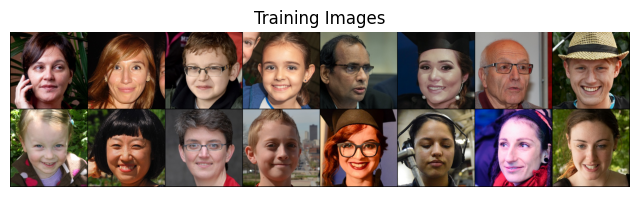

In [69]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [70]:
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname or "Linear" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [71]:

class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, base=G_HIDDEN):
        super().__init__()
        # Start from 4x4 and upsample to 256x256
        self.init_size = 4
        self.linear = nn.Sequential(
            nn.Linear(z_dim, base * 8 * self.init_size * self.init_size),
            nn.BatchNorm1d(base * 8 * self.init_size * self.init_size),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            nn.Unflatten(1, (base * 8, self.init_size, self.init_size)),

            # 4x4 -> 8x8
            nn.ConvTranspose2d(base * 8, base * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(base * 4, base * 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(base * 4, base * 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base * 2),
            nn.ReLU(True),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(base * 2, base, 4, stride=2, padding=1),
            nn.BatchNorm2d(base),
            nn.ReLU(True),

            # 64x64 -> 128x128
            nn.ConvTranspose2d(base, base // 2, 4, stride=2, padding=1),
            nn.BatchNorm2d(base // 2),
            nn.ReLU(True),

            # 128x128 -> 256x256
            nn.ConvTranspose2d(base // 2, IMG_CHANNELS, 4, stride=2, padding=1),
            nn.Tanh()  # -> [-1,1]
        )

    def forward(self, z):
        x = self.linear(z)
        return self.conv_blocks(x)

G = Generator().to(device)
G.apply(weights_init)
G

Generator(
  (linear): Sequential(
    (0): Linear(in_features=200, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [72]:

class Discriminator(nn.Module):
    def __init__(self, base=D_HIDDEN):
        super().__init__()
        # For 256x256 input
        self.net = nn.Sequential(
            # 256x256 -> 128x128
            nn.Conv2d(IMG_CHANNELS, base // 2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # 128x128 -> 64x64
            nn.Conv2d(base // 2, base, 4, 2, 1),
            nn.BatchNorm2d(base),
            nn.LeakyReLU(0.2, inplace=True),

            # 64x64 -> 32x32
            nn.Conv2d(base, base * 2, 4, 2, 1),
            nn.BatchNorm2d(base * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32 -> 16x16
            nn.Conv2d(base * 2, base * 4, 4, 2, 1),
            nn.BatchNorm2d(base * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 -> 8x8
            nn.Conv2d(base * 4, base * 4, 4, 2, 1),
            nn.BatchNorm2d(base * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 -> 4x4
            nn.Conv2d(base * 4, base * 8, 4, 2, 1),
            nn.BatchNorm2d(base * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # 4x4 -> 1
            nn.Conv2d(base * 8, 1, 4, 1, 0),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x).view(-1)

D = Discriminator().to(device)
D.apply(weights_init)
D


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): L

In [73]:
opt_G = torch.optim.Adam(G.parameters(), lr=G_LR, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=D_LR, betas=BETAS)

criterion = nn.BCEWithLogitsLoss()

fixed_z = torch.randn(64, Z_DIM, device=device)  # for consistent snapshots

In [74]:
@torch.no_grad()
def save_samples(step_tag="init"):
    G.eval()
    fake = G(fixed_z).cpu()
    grid = torchvision.utils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
    torchvision.utils.save_image(grid, f"{OUT_DIR}/samples_{step_tag}.png")
    G.train()

def show_image(path):
    img = plt.imread(path)
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(img)

In [75]:

img_list = []
G_losses = []
D_losses = []

In [76]:
def save_model(epoch):
    """Saves the model and optimizer state dictionaries."""
    state = {
        'epoch': epoch,
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'opt_G_state_dict': opt_G.state_dict(),
        'opt_D_state_dict': opt_D.state_dict(),
    }
    checkpoint_filename = f"{OUT_DIR}/checkpoint_epoch_{epoch:03d}.pth"
    latest_checkpoint_filename = f"{OUT_DIR}/latest_checkpoint.pth"
    torch.save(state, checkpoint_filename)
    torch.save(state, latest_checkpoint_filename) # Save as latest checkpoint as well
    print(f"Checkpoint saved for epoch {epoch}")

In [77]:
def load_checkpoint(filepath):
    """Loads a model checkpoint and resumes training."""
    if os.path.isfile(filepath):
        print(f"Loading checkpoint '{filepath}'")
        checkpoint = torch.load(filepath)
        start_epoch = checkpoint['epoch']
        G.load_state_dict(checkpoint['G_state_dict'])
        D.load_state_dict(checkpoint['D_state_dict'])
        opt_G.load_state_dict(checkpoint['opt_G_state_dict'])
        opt_D.load_state_dict(checkpoint['opt_D_state_dict'])
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
        return start_epoch
    else:
        print(f"No checkpoint found at '{filepath}'")
        return 0 # Start from epoch 0 if no checkpoint is found

# Example usage:
# checkpoint_path = f"{OUT_DIR}/checkpoint_epoch_{EPOCHS:03d}.pth" # or the desired checkpoint
# start_epoch = load_checkpoint(checkpoint_path)

# Then modify your training loop to start from `start_epoch + 1`

In [78]:
from math import inf

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

opt_G = torch.optim.Adam(G.parameters(), lr=G_LR, betas=BETAS)
opt_D = torch.optim.Adam(D.parameters(), lr=D_LR, betas=BETAS)

criterion = nn.BCEWithLogitsLoss()

fixed_z = torch.randn(64, Z_DIM, device=device)  # for consistent snapshots


G.train(); D.train()
global_step = 0
save_samples("0000")

# Load checkpoint
checkpoint_path = f"{OUT_DIR}/latest_checkpoint.pth" # You can change the path to a specific checkpoint if needed
start_epoch = load_checkpoint(checkpoint_path)

for epoch in range(start_epoch + 1, EPOCHS + 1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for real, _ in pbar:
        real = real.to(device)  # (N,1,28,28)
        N = real.size(0)

        # -------------------------
        #  Train Discriminator
        # -------------------------
        opt_D.zero_grad(set_to_none=True)

        z = torch.randn(N, Z_DIM, device=device)
        fake = G(z).detach()

        real_logits = D(real)
        fake_logits = D(fake)

        real_labels = torch.ones(N, device=device)
        fake_labels = torch.zeros(N, device=device)

        d_loss_real = criterion(real_logits, real_labels)
        d_loss_fake = criterion(fake_logits, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # -------------------------
        #  Train Generator
        # -------------------------
        opt_G.zero_grad(set_to_none=True)

        z = torch.randn(N, Z_DIM, device=device)
        fake = G(z)
        fake_logits = D(fake)

        # want D to think fakes are real
        g_loss = criterion(fake_logits, torch.ones(N, device=device))
        g_loss.backward()
        opt_G.step()

        global_step += 1
        pbar.set_postfix(dloss=float(d_loss.item()), gloss=float(g_loss.item()))

    save_samples(f"epoch_{epoch:03d}")
    save_model(epoch) # Save model checkpoint after each epoch

No checkpoint found at 'CONFIG_4_AGGRESSIVE_G'/latest_checkpoint.pth'


Epoch 1/20: 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=2.19, gloss=10.5]


Checkpoint saved for epoch 1


Epoch 2/20: 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=0.299, gloss=6.21]


Checkpoint saved for epoch 2


Epoch 3/20: 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=0.0805, gloss=4.82]


Checkpoint saved for epoch 3


Epoch 4/20: 100%|██████████| 196/196 [01:12<00:00,  2.72it/s, dloss=0.0611, gloss=4.55]


Checkpoint saved for epoch 4


Epoch 5/20: 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=0.0617, gloss=5.12]


Checkpoint saved for epoch 5


Epoch 6/20: 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=0.624, gloss=4.14]


Checkpoint saved for epoch 6


Epoch 7/20: 100%|██████████| 196/196 [01:12<00:00,  2.72it/s, dloss=1.14, gloss=3.36]


Checkpoint saved for epoch 7


Epoch 8/20: 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=0.64, gloss=2.36]


Checkpoint saved for epoch 8


Epoch 9/20: 100%|██████████| 196/196 [01:12<00:00,  2.72it/s, dloss=0.505, gloss=4.05]


Checkpoint saved for epoch 9


Epoch 10/20: 100%|██████████| 196/196 [01:13<00:00,  2.67it/s, dloss=0.868, gloss=1.83]


Checkpoint saved for epoch 10


Epoch 11/20: 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=3.11, gloss=1.33]


Checkpoint saved for epoch 11


Epoch 12/20: 100%|██████████| 196/196 [01:12<00:00,  2.72it/s, dloss=0.995, gloss=3.62]


Checkpoint saved for epoch 12


Epoch 13/20: 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.846, gloss=1.67]


Checkpoint saved for epoch 13


Epoch 14/20: 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=1.02, gloss=1.47]


Checkpoint saved for epoch 14


Epoch 15/20: 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=1.27, gloss=0.922]


Checkpoint saved for epoch 15


Epoch 16/20: 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=1.95, gloss=4.53]


Checkpoint saved for epoch 16


Epoch 17/20: 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=1.17, gloss=4.06]


Checkpoint saved for epoch 17


Epoch 18/20: 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=1.01, gloss=4.39]


Checkpoint saved for epoch 18


Epoch 19/20: 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=1.19, gloss=3.91]


Checkpoint saved for epoch 19


Epoch 20/20: 100%|██████████| 196/196 [01:13<00:00,  2.65it/s, dloss=0.56, gloss=3.39]


Checkpoint saved for epoch 20


Showing: samples_epoch_020.png


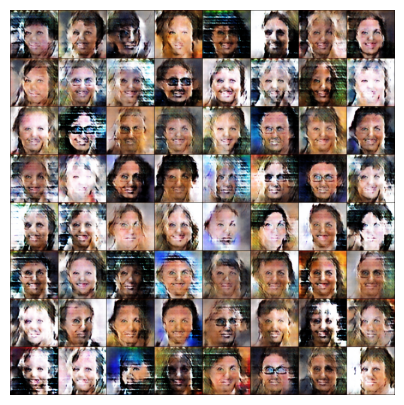

In [79]:
latest = sorted(os.listdir(OUT_DIR))[-1]
print("Showing:", latest)
show_image(os.path.join(OUT_DIR, latest))

# Task
Create a systematic way to modify hyperparameters in 5 OUT_DIR named BASELINE, CONFIG_1_TTUR, CONFIG_2_CAPACITY, CONFIG_3_CONSERVATIVE, CONFIG_4_AGGRESSIVE_G' with different values for Z_DIM, G_HIDDEN, D_HIDDEN, BATCH_SIZE, G_LR, D_LR, where folder name can be passed in as a parameter to auto-determine OUT_DIR and other hyperparameters.

## Define configurations

### Subtask:
Create a dictionary or similar structure to hold the hyperparameters for each configuration (BASELINE, CONFIG_1_TTUR, etc.), using the folder name as the key.


**Reasoning**:
Create a dictionary to store hyperparameter configurations for different training runs, including a baseline and several configurations with modified parameters.



In [80]:
configs = {
    "BASELINE": {
        'Z_DIM': 200,
        'G_HIDDEN': 64,
        'D_HIDDEN': 64,
        'BATCH_SIZE': 256,
        'G_LR': 3e-4,
        'D_LR': 1e-4,
    },
    "CONFIG_1_TTUR": { # TTUR: Two Time-Scale Update Rule
        'Z_DIM': 200,
        'G_HIDDEN': 64,
        'D_HIDDEN': 64,
        'BATCH_SIZE': 256,
        'G_LR': 1e-4, # Lower G_LR
        'D_LR': 4e-4, # Higher D_LR (TTUR suggests D_LR = 4*G_LR)
    },
    "CONFIG_2_CAPACITY": { # Increased model capacity
        'Z_DIM': 200,
        'G_HIDDEN': 128, # Increased G capacity
        'D_HIDDEN': 128, # Increased D capacity
        'BATCH_SIZE': 256,
        'G_LR': 3e-4,
        'D_LR': 1e-4,
    },
    "CONFIG_3_CONSERVATIVE": { # More conservative training
        'Z_DIM': 100, # Smaller latent space
        'G_HIDDEN': 64,
        'D_HIDDEN': 64,
        'BATCH_SIZE': 128, # Smaller batch size
        'G_LR': 1e-4, # Lower G_LR
        'D_LR': 5e-5, # Lower D_LR
    },
    "CONFIG_4_AGGRESSIVE_G": { # Aggressive Generator
        'Z_DIM': 200,
        'G_HIDDEN': 64,
        'D_HIDDEN': 64,
        'BATCH_SIZE': 256,
        'G_LR': 3e-4, # Aggressive G_LR (same as baseline, but could be higher)
        'D_LR': 1e-4, # D_LR (same as baseline, but could be lower)
    },
}

print(configs)

{'BASELINE': {'Z_DIM': 200, 'G_HIDDEN': 64, 'D_HIDDEN': 64, 'BATCH_SIZE': 256, 'G_LR': 0.0003, 'D_LR': 0.0001}, 'CONFIG_1_TTUR': {'Z_DIM': 200, 'G_HIDDEN': 64, 'D_HIDDEN': 64, 'BATCH_SIZE': 256, 'G_LR': 0.0001, 'D_LR': 0.0004}, 'CONFIG_2_CAPACITY': {'Z_DIM': 200, 'G_HIDDEN': 128, 'D_HIDDEN': 128, 'BATCH_SIZE': 256, 'G_LR': 0.0003, 'D_LR': 0.0001}, 'CONFIG_3_CONSERVATIVE': {'Z_DIM': 100, 'G_HIDDEN': 64, 'D_HIDDEN': 64, 'BATCH_SIZE': 128, 'G_LR': 0.0001, 'D_LR': 5e-05}, 'CONFIG_4_AGGRESSIVE_G': {'Z_DIM': 200, 'G_HIDDEN': 64, 'D_HIDDEN': 64, 'BATCH_SIZE': 256, 'G_LR': 0.0003, 'D_LR': 0.0001}}


## Implement a function to set hyperparameters

### Subtask:
Create a Python function that takes the configuration name as input and updates the global hyperparameter variables (Z_DIM, G_HIDDEN, etc.) and the `OUT_DIR`.


**Reasoning**:
Define a function to update global hyperparameters based on the provided configuration name.



In [81]:
def set_config(config_name):
    """
    Updates global hyperparameters based on the specified configuration name.

    Args:
        config_name (str): The name of the configuration to load.
    """
    global Z_DIM, G_HIDDEN, D_HIDDEN, BATCH_SIZE, G_LR, D_LR, OUT_DIR

    if config_name not in configs:
        print(f"Error: Configuration '{config_name}' not found.")
        return

    config = configs[config_name]

    Z_DIM = config['Z_DIM']
    G_HIDDEN = config['G_HIDDEN']
    D_HIDDEN = config['D_HIDDEN']
    BATCH_SIZE = config['BATCH_SIZE']
    G_LR = config['G_LR']
    D_LR = config['D_LR']
    OUT_DIR = f"{config_name}_OUTPUT" # Update OUT_DIR based on config name
    os.makedirs(OUT_DIR, exist_ok=True) # Ensure the output directory exists


    print(f"Hyperparameters updated for configuration: {config_name}")
    print(f"  Z_DIM: {Z_DIM}")
    print(f"  G_HIDDEN: {G_HIDDEN}")
    print(f"  D_HIDDEN: {D_HIDDEN}")
    print(f"  BATCH_SIZE: {BATCH_SIZE}")
    print(f"  G_LR: {G_LR}")
    print(f"  D_LR: {D_LR}")
    print(f"  OUT_DIR: {OUT_DIR}")

# Example usage:
# set_config("CONFIG_1_TTUR")
# print(f"Current OUT_DIR: {OUT_DIR}")

## Modify training loop to use configurations

### Subtask:
Update the training loop to iterate through the defined configurations. Inside the loop, call the hyperparameter setting function and then execute the training process for that configuration.


**Reasoning**:
The goal is to iterate through the defined configurations and train the GAN for each. This requires looping through the `configs` dictionary, setting the hyperparameters using `set_config`, re-initializing the model components with the new hyperparameters, and then running the training loop for the specified number of epochs. The save functions also need to use the correct `OUT_DIR` for the current configuration.



In [82]:
from math import inf

for config_name, config_params in configs.items():
    print(f"\n--- Training with configuration: {config_name} ---")

    # Set hyperparameters and output directory for the current config
    set_config(config_name)

    # Re-initialize models, optimizers, and criterion with new hyperparameters
    G = Generator(z_dim=Z_DIM, base=G_HIDDEN).to(device)
    G.apply(weights_init)

    D = Discriminator(base=D_HIDDEN).to(device)
    D.apply(weights_init)

    opt_G = torch.optim.Adam(G.parameters(), lr=G_LR, betas=BETAS)
    opt_D = torch.optim.Adam(D.parameters(), lr=D_LR, betas=BETAS)

    criterion = nn.BCEWithLogitsLoss()

    # Re-create fixed_z for consistent snapshots in the new config
    fixed_z = torch.randn(64, Z_DIM, device=device)

    G.train(); D.train()
    global_step = 0

    # Save initial samples for the current config
    save_samples(step_tag="0000")

    # Load checkpoint for the current config
    checkpoint_path = f"{OUT_DIR}/latest_checkpoint.pth"
    start_epoch = load_checkpoint(checkpoint_path)

    # Re-initialize DataLoader if BATCH_SIZE changed
    if train_loader.batch_size != BATCH_SIZE:
         train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
         print(f"DataLoader re-initialized with batch size: {BATCH_SIZE}")


    for epoch in range(start_epoch + 1, EPOCHS + 1):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} ({config_name})")
        for real, _ in pbar:
            real = real.to(device)
            N = real.size(0)

            # -------------------------
            #  Train Discriminator
            # -------------------------
            opt_D.zero_grad(set_to_none=True)

            z = torch.randn(N, Z_DIM, device=device)
            fake = G(z).detach()

            real_logits = D(real)
            fake_logits = D(fake)

            real_labels = torch.ones(N, device=device)
            fake_labels = torch.zeros(N, device=device)

            d_loss_real = criterion(real_logits, real_labels)
            d_loss_fake = criterion(fake_logits, fake_labels)
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            opt_D.step()

            # -------------------------
            #  Train Generator
            # -------------------------
            opt_G.zero_grad(set_to_none=True)

            z = torch.randn(N, Z_DIM, device=device)
            fake = G(z)
            fake_logits = D(fake)

            # want D to think fakes are real
            g_loss = criterion(fake_logits, torch.ones(N, device=device))
            g_loss.backward()
            opt_G.step()

            global_step += 1
            pbar.set_postfix(dloss=float(d_loss.item()), gloss=float(g_loss.item()))

        # Save samples and model checkpoint after each epoch for the current config
        save_samples(f"epoch_{epoch:03d}")
        save_model(epoch)

    print(f"--- Finished training for configuration: {config_name} ---")



--- Training with configuration: BASELINE ---
Hyperparameters updated for configuration: BASELINE
  Z_DIM: 200
  G_HIDDEN: 64
  D_HIDDEN: 64
  BATCH_SIZE: 256
  G_LR: 0.0003
  D_LR: 0.0001
  OUT_DIR: BASELINE_OUTPUT
No checkpoint found at 'BASELINE_OUTPUT/latest_checkpoint.pth'


Epoch 1/20 (BASELINE): 100%|██████████| 196/196 [01:13<00:00,  2.66it/s, dloss=1.34, gloss=7.15]


Checkpoint saved for epoch 1


Epoch 2/20 (BASELINE): 100%|██████████| 196/196 [01:14<00:00,  2.63it/s, dloss=0.242, gloss=4.62]


Checkpoint saved for epoch 2


Epoch 3/20 (BASELINE): 100%|██████████| 196/196 [01:15<00:00,  2.59it/s, dloss=0.0228, gloss=5.1]


Checkpoint saved for epoch 3


Epoch 4/20 (BASELINE): 100%|██████████| 196/196 [01:16<00:00,  2.56it/s, dloss=0.026, gloss=5.52]


Checkpoint saved for epoch 4


Epoch 5/20 (BASELINE): 100%|██████████| 196/196 [01:15<00:00,  2.59it/s, dloss=0.331, gloss=4.23]


Checkpoint saved for epoch 5


Epoch 6/20 (BASELINE): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.43, gloss=2.57]


Checkpoint saved for epoch 6


Epoch 7/20 (BASELINE): 100%|██████████| 196/196 [01:16<00:00,  2.57it/s, dloss=0.71, gloss=3.56]


Checkpoint saved for epoch 7


Epoch 8/20 (BASELINE): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.554, gloss=2.39]


Checkpoint saved for epoch 8


Epoch 9/20 (BASELINE): 100%|██████████| 196/196 [01:13<00:00,  2.65it/s, dloss=0.792, gloss=2.88]


Checkpoint saved for epoch 9


Epoch 10/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.863, gloss=1.97]


Checkpoint saved for epoch 10


Epoch 11/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.971, gloss=1.32]


Checkpoint saved for epoch 11


Epoch 12/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.72it/s, dloss=1.59, gloss=0.0664]


Checkpoint saved for epoch 12


Epoch 13/20 (BASELINE): 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=1.09, gloss=3.45]


Checkpoint saved for epoch 13


Epoch 14/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.871, gloss=1.6]


Checkpoint saved for epoch 14


Epoch 15/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.752, gloss=1.41]


Checkpoint saved for epoch 15


Epoch 16/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.679, gloss=2.79]


Checkpoint saved for epoch 16


Epoch 17/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=1.18, gloss=0.978]


Checkpoint saved for epoch 17


Epoch 18/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=1.08, gloss=1.76]


Checkpoint saved for epoch 18


Epoch 19/20 (BASELINE): 100%|██████████| 196/196 [01:11<00:00,  2.74it/s, dloss=0.813, gloss=3.99]


Checkpoint saved for epoch 19


Epoch 20/20 (BASELINE): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=0.748, gloss=3.52]


Checkpoint saved for epoch 20
--- Finished training for configuration: BASELINE ---

--- Training with configuration: CONFIG_1_TTUR ---
Hyperparameters updated for configuration: CONFIG_1_TTUR
  Z_DIM: 200
  G_HIDDEN: 64
  D_HIDDEN: 64
  BATCH_SIZE: 256
  G_LR: 0.0001
  D_LR: 0.0004
  OUT_DIR: CONFIG_1_TTUR_OUTPUT
No checkpoint found at 'CONFIG_1_TTUR_OUTPUT/latest_checkpoint.pth'


Epoch 1/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.0461, gloss=5.21]


Checkpoint saved for epoch 1


Epoch 2/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=0.0485, gloss=5.3]


Checkpoint saved for epoch 2


Epoch 3/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.313, gloss=3.47]


Checkpoint saved for epoch 3


Epoch 4/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=0.328, gloss=4.12]


Checkpoint saved for epoch 4


Epoch 5/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=0.288, gloss=6.97]


Checkpoint saved for epoch 5


Epoch 6/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:13<00:00,  2.66it/s, dloss=0.323, gloss=3.81]


Checkpoint saved for epoch 6


Epoch 7/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:13<00:00,  2.66it/s, dloss=0.384, gloss=5.38]


Checkpoint saved for epoch 7


Epoch 8/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.136, gloss=5.74]


Checkpoint saved for epoch 8


Epoch 9/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.304, gloss=3.8]


Checkpoint saved for epoch 9


Epoch 10/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:13<00:00,  2.68it/s, dloss=0.474, gloss=8.16]


Checkpoint saved for epoch 10


Epoch 11/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:13<00:00,  2.67it/s, dloss=0.111, gloss=6.44]


Checkpoint saved for epoch 11


Epoch 12/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:13<00:00,  2.66it/s, dloss=0.252, gloss=6.12]


Checkpoint saved for epoch 12


Epoch 13/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=1.65, gloss=5.47]


Checkpoint saved for epoch 13


Epoch 14/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=0.222, gloss=4.74]


Checkpoint saved for epoch 14


Epoch 15/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.70it/s, dloss=0.447, gloss=8.78]


Checkpoint saved for epoch 15


Epoch 16/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:11<00:00,  2.73it/s, dloss=0.41, gloss=8.77]


Checkpoint saved for epoch 16


Epoch 17/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=0.204, gloss=8.36]


Checkpoint saved for epoch 17


Epoch 18/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.72it/s, dloss=2.76, gloss=18.9]


Checkpoint saved for epoch 18


Epoch 19/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:12<00:00,  2.71it/s, dloss=0.0351, gloss=8.2]


Checkpoint saved for epoch 19


Epoch 20/20 (CONFIG_1_TTUR): 100%|██████████| 196/196 [01:13<00:00,  2.68it/s, dloss=0.217, gloss=12]


Checkpoint saved for epoch 20
--- Finished training for configuration: CONFIG_1_TTUR ---

--- Training with configuration: CONFIG_2_CAPACITY ---
Hyperparameters updated for configuration: CONFIG_2_CAPACITY
  Z_DIM: 200
  G_HIDDEN: 128
  D_HIDDEN: 128
  BATCH_SIZE: 256
  G_LR: 0.0003
  D_LR: 0.0001
  OUT_DIR: CONFIG_2_CAPACITY_OUTPUT
No checkpoint found at 'CONFIG_2_CAPACITY_OUTPUT/latest_checkpoint.pth'


Epoch 1/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:12<00:00,  2.69it/s, dloss=1.36, gloss=20.8]


Checkpoint saved for epoch 1


Epoch 2/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:17<00:00,  2.52it/s, dloss=0.319, gloss=6.79]


Checkpoint saved for epoch 2


Epoch 3/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:18<00:00,  2.51it/s, dloss=0.0132, gloss=6.33]


Checkpoint saved for epoch 3


Epoch 4/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:18<00:00,  2.50it/s, dloss=0.00649, gloss=6.38]


Checkpoint saved for epoch 4


Epoch 5/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:17<00:00,  2.51it/s, dloss=0.00465, gloss=6.17]


Checkpoint saved for epoch 5


Epoch 6/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:18<00:00,  2.51it/s, dloss=0.0314, gloss=6.6]


Checkpoint saved for epoch 6


Epoch 7/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:17<00:00,  2.52it/s, dloss=0.0619, gloss=5]


Checkpoint saved for epoch 7


Epoch 8/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:18<00:00,  2.49it/s, dloss=0.00118, gloss=6.82]


Checkpoint saved for epoch 8


Epoch 9/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:13<00:00,  2.66it/s, dloss=0.756, gloss=3.76]


Checkpoint saved for epoch 9


Epoch 10/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, dloss=0.642, gloss=2.38]


Checkpoint saved for epoch 10


Epoch 11/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, dloss=1.7, gloss=3.41]


Checkpoint saved for epoch 11


Epoch 12/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:21<00:00,  2.39it/s, dloss=0.944, gloss=1.52]


Checkpoint saved for epoch 12


Epoch 13/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, dloss=0.654, gloss=2.54]


Checkpoint saved for epoch 13


Epoch 14/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:15<00:00,  2.59it/s, dloss=0.396, gloss=3.93]


Checkpoint saved for epoch 14


Epoch 15/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, dloss=1.47, gloss=5.24]


Checkpoint saved for epoch 15


Epoch 16/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:15<00:00,  2.59it/s, dloss=0.869, gloss=5]


Checkpoint saved for epoch 16


Epoch 17/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:19<00:00,  2.46it/s, dloss=0.904, gloss=3.74]


Checkpoint saved for epoch 17


Epoch 18/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:16<00:00,  2.57it/s, dloss=1.08, gloss=4.22]


Checkpoint saved for epoch 18


Epoch 19/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, dloss=0.587, gloss=2.74]


Checkpoint saved for epoch 19


Epoch 20/20 (CONFIG_2_CAPACITY): 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, dloss=0.877, gloss=7.1]


Checkpoint saved for epoch 20
--- Finished training for configuration: CONFIG_2_CAPACITY ---

--- Training with configuration: CONFIG_3_CONSERVATIVE ---
Hyperparameters updated for configuration: CONFIG_3_CONSERVATIVE
  Z_DIM: 100
  G_HIDDEN: 64
  D_HIDDEN: 64
  BATCH_SIZE: 128
  G_LR: 0.0001
  D_LR: 5e-05
  OUT_DIR: CONFIG_3_CONSERVATIVE_OUTPUT
No checkpoint found at 'CONFIG_3_CONSERVATIVE_OUTPUT/latest_checkpoint.pth'
DataLoader re-initialized with batch size: 128


Epoch 1/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:16<00:00,  5.13it/s, dloss=0.387, gloss=6.32]


Checkpoint saved for epoch 1


Epoch 2/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:16<00:00,  5.09it/s, dloss=0.055, gloss=5.11]


Checkpoint saved for epoch 2


Epoch 3/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:16<00:00,  5.14it/s, dloss=0.0291, gloss=5.49]


Checkpoint saved for epoch 3


Epoch 4/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:15<00:00,  5.20it/s, dloss=0.00221, gloss=6.68]


Checkpoint saved for epoch 4


Epoch 5/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.23it/s, dloss=0.00113, gloss=7.36]


Checkpoint saved for epoch 5


Epoch 6/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:15<00:00,  5.19it/s, dloss=0.000623, gloss=7.97]


Checkpoint saved for epoch 6


Epoch 7/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.25it/s, dloss=0.000157, gloss=9.15]


Checkpoint saved for epoch 7


Epoch 8/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:12<00:00,  5.37it/s, dloss=0.000372, gloss=8.66]


Checkpoint saved for epoch 8


Epoch 9/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:43<00:00,  3.79it/s, dloss=0.000118, gloss=9.35]


Checkpoint saved for epoch 9


Epoch 10/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:28<00:00,  4.40it/s, dloss=0.000147, gloss=10.5]


Checkpoint saved for epoch 10


Epoch 11/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, dloss=4.69e-5, gloss=10.3]


Checkpoint saved for epoch 11


Epoch 12/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.25it/s, dloss=9.06e-5, gloss=9.61]


Checkpoint saved for epoch 12


Epoch 13/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.23it/s, dloss=6.74e-5, gloss=9.92]


Checkpoint saved for epoch 13


Epoch 14/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.23it/s, dloss=8.03e-5, gloss=9.76]


Checkpoint saved for epoch 14


Epoch 15/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.24it/s, dloss=4.78e-5, gloss=10.4]


Checkpoint saved for epoch 15


Epoch 16/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:15<00:00,  5.19it/s, dloss=3.15e-5, gloss=10.7]


Checkpoint saved for epoch 16


Epoch 17/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.24it/s, dloss=1.06e-5, gloss=13.1]


Checkpoint saved for epoch 17


Epoch 18/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.24it/s, dloss=0.000148, gloss=9.55]


Checkpoint saved for epoch 18


Epoch 19/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:15<00:00,  5.19it/s, dloss=0.116, gloss=7.74]


Checkpoint saved for epoch 19


Epoch 20/20 (CONFIG_3_CONSERVATIVE): 100%|██████████| 391/391 [01:14<00:00,  5.24it/s, dloss=0.132, gloss=3.76]


Checkpoint saved for epoch 20
--- Finished training for configuration: CONFIG_3_CONSERVATIVE ---

--- Training with configuration: CONFIG_4_AGGRESSIVE_G ---
Hyperparameters updated for configuration: CONFIG_4_AGGRESSIVE_G
  Z_DIM: 200
  G_HIDDEN: 64
  D_HIDDEN: 64
  BATCH_SIZE: 256
  G_LR: 0.0003
  D_LR: 0.0001
  OUT_DIR: CONFIG_4_AGGRESSIVE_G_OUTPUT
No checkpoint found at 'CONFIG_4_AGGRESSIVE_G_OUTPUT/latest_checkpoint.pth'
DataLoader re-initialized with batch size: 256


Epoch 1/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.61it/s, dloss=1.14, gloss=8.17]


Checkpoint saved for epoch 1


Epoch 2/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.441, gloss=6.36]


Checkpoint saved for epoch 2


Epoch 3/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.0528, gloss=4.83]


Checkpoint saved for epoch 3


Epoch 4/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.61it/s, dloss=0.0283, gloss=4.99]


Checkpoint saved for epoch 4


Epoch 5/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:14<00:00,  2.63it/s, dloss=0.00914, gloss=5.91]


Checkpoint saved for epoch 5


Epoch 6/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.0027, gloss=6.72]


Checkpoint saved for epoch 6


Epoch 7/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:14<00:00,  2.62it/s, dloss=0.00391, gloss=6.08]


Checkpoint saved for epoch 7


Epoch 8/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:14<00:00,  2.63it/s, dloss=0.0212, gloss=6.88]


Checkpoint saved for epoch 8


Epoch 9/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=1.13, gloss=3.95]


Checkpoint saved for epoch 9


Epoch 10/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.60it/s, dloss=0.827, gloss=1.04]


Checkpoint saved for epoch 10


Epoch 11/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.61it/s, dloss=0.376, gloss=3.21]


Checkpoint saved for epoch 11


Epoch 12/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.59it/s, dloss=0.688, gloss=3.27]


Checkpoint saved for epoch 12


Epoch 13/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:16<00:00,  2.57it/s, dloss=0.778, gloss=1.58]


Checkpoint saved for epoch 13


Epoch 14/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:16<00:00,  2.57it/s, dloss=0.723, gloss=2.39]


Checkpoint saved for epoch 14


Epoch 15/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:16<00:00,  2.56it/s, dloss=0.735, gloss=2.12]


Checkpoint saved for epoch 15


Epoch 16/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:15<00:00,  2.59it/s, dloss=1.22, gloss=2.2]


Checkpoint saved for epoch 16


Epoch 17/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:16<00:00,  2.56it/s, dloss=1.07, gloss=1.87]


Checkpoint saved for epoch 17


Epoch 18/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:16<00:00,  2.55it/s, dloss=0.967, gloss=5.71]


Checkpoint saved for epoch 18


Epoch 19/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:17<00:00,  2.52it/s, dloss=0.913, gloss=2.51]


Checkpoint saved for epoch 19


Epoch 20/20 (CONFIG_4_AGGRESSIVE_G): 100%|██████████| 196/196 [01:16<00:00,  2.58it/s, dloss=0.822, gloss=1.52]


Checkpoint saved for epoch 20
--- Finished training for configuration: CONFIG_4_AGGRESSIVE_G ---


**Reasoning**:
The subtask is to calculate the mean, median, and standard deviation of the 'price' column and display the results.



In [83]:
mean_price = df['price'].mean()
median_price = df['price'].median()
std_price = df['price'].std()
print(f"Mean price: {mean_price:.2f}")
print(f"Median price: {median_price:.2f}")
print(f"Standard deviation of price: {std_price:.2f}")

NameError: name 'df' is not defined

### Analyze Results and Produce Summary Report

--- Analyzing Results ---

Analyzing configuration: BASELINE
Hyperparameters used:
Generated samples for BASELINE:


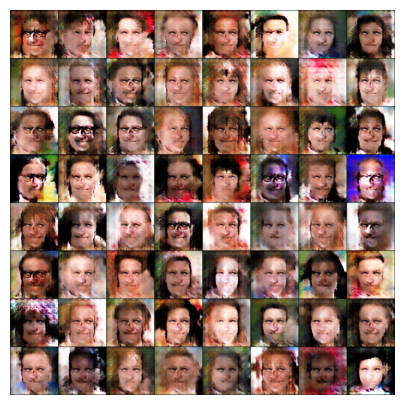


Analyzing configuration: CONFIG_1_TTUR
Hyperparameters used:
Generated samples for CONFIG_1_TTUR:


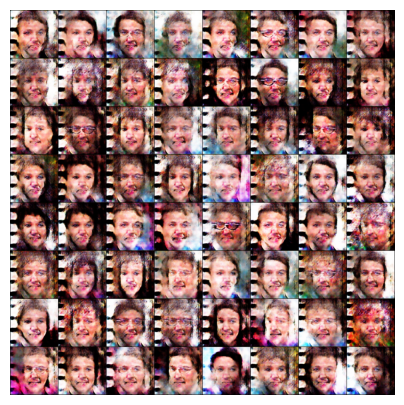


Analyzing configuration: CONFIG_2_CAPACITY
Hyperparameters used:
Generated samples for CONFIG_2_CAPACITY:


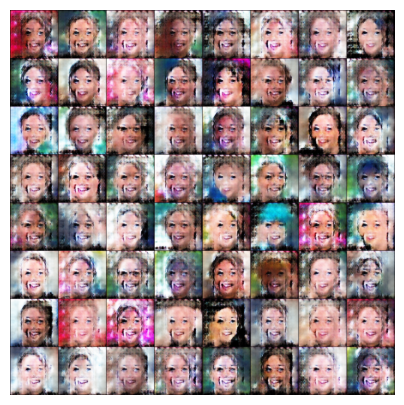


Analyzing configuration: CONFIG_3_CONSERVATIVE
Hyperparameters used:
Generated samples for CONFIG_3_CONSERVATIVE:


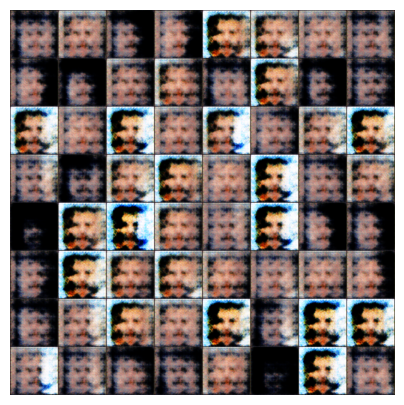


Analyzing configuration: CONFIG_4_AGGRESSIVE_G
Hyperparameters used:
Generated samples for CONFIG_4_AGGRESSIVE_G:


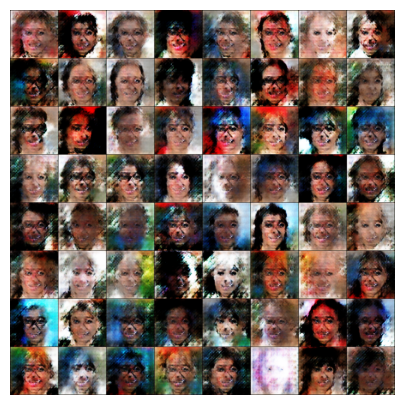


--- Analysis Complete ---


In [84]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils

# Assuming 'configs' dictionary is available from previous cells
# Assuming 'show_image' function is available from previous cells
# Assuming 'load_checkpoint' function is available from previous cells
# Assuming 'Generator' class is available from previous cells
# Assuming 'Discriminator' class is available from previous cells
# Assuming 'weights_init' function is available from previous cells
# Assuming 'device' is defined

print("--- Analyzing Results ---")

for config_name, config_params in configs.items():
    print(f"\nAnalyzing configuration: {config_name}")
    OUT_DIR = f"{config_name}_OUTPUT"
    checkpoint_path = f"{OUT_DIR}/latest_checkpoint.pth"
    samples_path = f"{OUT_DIR}/samples_epoch_{EPOCHS:03d}.png" # Assuming samples are saved at the last epoch

    if not os.path.exists(checkpoint_path) or not os.path.exists(samples_path):
        print(f"Results not found for {config_name}. Skipping analysis.")
        continue

    # Load checkpoint to get hyperparameters
    # Need to temporarily initialize models to load checkpoint
    temp_G = Generator(z_dim=config_params['Z_DIM'], base=config_params['G_HIDDEN']).to(device)
    temp_D = Discriminator(base=config_params['D_HIDDEN']).to(device)
    temp_opt_G = torch.optim.Adam(temp_G.parameters(), lr=config_params['G_LR'], betas=(0.5, 0.999))
    temp_opt_D = torch.optim.Adam(temp_D.parameters(), lr=config_params['D_LR'], betas=(0.5, 0.999))


    checkpoint = torch.load(checkpoint_path, map_location=device)

    print("Hyperparameters used:")
    for key, value in checkpoint.get('hyperparameters', {}).items():
        print(f"  {key}: {value}")

    # Display generated samples
    print(f"Generated samples for {config_name}:")
    show_image(samples_path)
    plt.show()

print("\n--- Analysis Complete ---")